<a id=top-page></a>
# Cost function analysis of the atmospheric physics dataset

In this notebook, we explore 2D and 3D projections of the atmospheric physics dataset using four reduction techniques: **PCA**, **UMAP**, **Isomap** and **t-SNE**.

The original dataset has `18540` and 16 variables. The target variable of interest is the turbulent Schmidt number, $\phi = Sc_t$. The dataset used here comes from a delayed-detached eddy simulation of an atmospheric dispersion of a pollutant in the viscinity of a rectangular building. We use a single spatial snapshot from the dataset. More information can be found in:

> [Longo et al., *A multi-fidelity framework for the estimation of the turbulent Schmidt number in the simulation of atmospheric dispersion*](https://www.sciencedirect.com/science/article/abs/pii/S0360132320304467?via%3Dihub).

The analysis in this notebook is performed in the following steps:

- [Load the atmospheric physics data](#load-data)
- [Run costs across changing scalings for the four selected reduction techniques](#run-scalings-ranking)
- [Visualize the best 2D and 3D projections for the four selected reduction techniques](#visualize-projections)
- [Nonlinear regression of the turbulent Schmidt number, $Sc_t$, using artificial neural networks (ANNs)](#regression)
- [Plot the scalings ranking vs. MAE regression errors for all four reduction techniques](#plot-scalings-ranking)

***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
bandwidth_values = np.logspace(-7, 3, 200)
penalty = 'log-sigma-over-peak'
norm = 'max'
power = 1
colormap = 'plasma'
save_figures = True
techniques = ['PCA', 'UMAP', 'Isomap', 't-SNE']
data_tag = 'atmospheric-dispersion'
scalings_list = ['none', 'auto', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'vast_2', 'vast_3', 'vast_4']
tex_scalings_list = ['None', 'Auto', 'Pareto', 'VAST', 'Range', '$\\langle 0, 1 \\rangle$', '$\\langle -1, 1 \\rangle$', 'Level', 'Max', 'S1', 'S2', 'S3']

In [3]:
def compute_projection(X, method, scaling, n_components):

    if method == 'PCA':
        pca = reduction.PCA(X, n_components=n_components, scaling=scaling)
        X_projected = pca.transform(X)

    if method == 'UMAP':
        (X_cs, _, _) = preprocess.center_scale(X, scaling=scaling)
        X_projected = umap.UMAP(n_components=n_components, random_state=random_seed, n_neighbors=12).fit_transform(X_cs)
        
    if method == 'Isomap':
        (X_cs, _, _) = preprocess.center_scale(X, scaling=scaling)
        X_projected = manifold.Isomap(n_components=n_components).fit_transform(X_cs)

    if method == 't-SNE':
        (X_cs, _, _) = preprocess.center_scale(X, scaling=scaling)
        X_projected = manifold.TSNE(n_components=n_components, init="pca", random_state=random_seed).fit_transform(X_cs)

    return X_projected

<a id=load-data></a>
***

## Load the atmospheric physics data

[Go to the top](#top-page)

In [4]:
X = pd.read_csv('../data/atmospheric-physics-state-space.csv', header=None).to_numpy()
X_names = pd.read_csv('../data/atmospheric-physics-state-space-names.csv', header=None).to_numpy().ravel()
X_Sct = pd.read_csv('../data/atmospheric-physics-turbulent-Schmidt-number.csv', header=None).to_numpy().ravel()
(n_observations, n_variables) = X.shape

Remove multivariate outliers from the dataset:

In [5]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, 
                                                                    'auto', 
                                                                    method='PC CLASSIFIER', 
                                                                    quantile_threshold=0.98,
                                                                    verbose=True)

Major components that will be selected are: 1, 2
Minor components that will be selected are: 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
Number of observations classified as outliers: 509


Visualize which observations (transparent red) were classified as outliers:

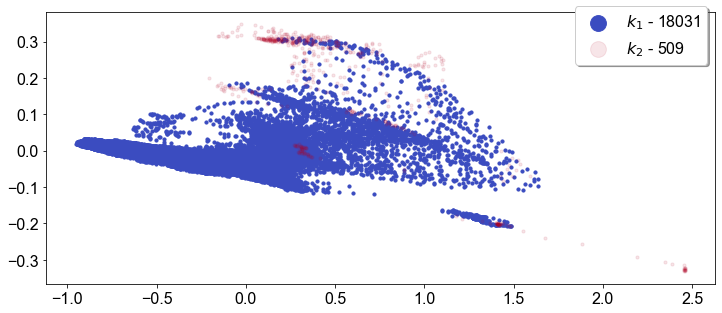

In [6]:
pca = reduction.PCA(X, scaling='vast_2', n_components=2)
PCs = pca.transform(X)

idx_outlier_classification = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_outlier_classification[i] = 1

plt = preprocess.plot_2d_clustering(PCs[:,0],
                                    PCs[:,1],
                                    idx_outlier_classification.astype(int),
                                    first_cluster_index_zero=False,
                                    alphas=[1,0.1],
                                    color_map='coolwarm',
                                    figure_size=(12,5))

In [7]:
X = X[idx_outliers_removed,:]
X_Sct = X_Sct[idx_outliers_removed]

In [8]:
(n_observations, n_variables) = np.shape(X)

In [9]:
df = pd.DataFrame(X, columns=X_names)
df.head(5)

,mean-adimensional-so2-concentration-cedval,mean-cmu,mean-cmu_udmi,mean-returb_newnew,mean-reynolds_taylor,mean-strainrate_invariant,mean-tdr,mean-tke,mean-turbulent_viscosity,mean-vorticity_invariant,mean-pressure,mean-velocity-magnitude,mean-x-velocity,mean-y-velocity,mean-z-velocity,mean-so2-mass-fraction
0,7.589239e-17,0.120914,0.112680,36.163684,14.641707,2.590408,0.029349,0.004010,0.000077,2.583404,-0.536585,5.810294,5.808888,0.125974,0.021698,1.058913e-22
1,3.069404e-16,0.119284,0.111498,35.890861,14.587817,2.640894,0.030174,0.004044,0.000076,2.632289,-0.593108,5.793331,5.792519,0.094196,0.023106,4.282684e-22
2,8.138288e-17,0.121578,0.113265,36.049590,14.619897,2.580683,0.029152,0.003990,0.000078,2.536158,-0.539561,5.806699,5.805250,0.128517,0.017511,1.135521e-22
3,7.410833e-20,0.132760,0.123630,34.940873,14.426364,2.132717,0.022178,0.003446,0.000084,2.083121,-0.313442,5.866979,5.864413,0.172046,0.022352,1.034020e-25
4,3.284680e-16,0.120153,0.112282,35.827429,14.575634,2.616993,0.029985,0.004030,0.000076,2.571794,-0.596624,5.787410,5.786557,0.097713,0.018038,4.583054e-22


<a id=run-scalings-ranking></a>
***

## Run costs across changing scalings for the four selected reduction techniques

[Go to the top](#top-page)

<p style="color:green;">► You only need to run this once to generate the `csv` files in `../results/`:</p>

In [ ]:
for technique in techniques:
    
    for n_components in [2, 3]:
    
        print('Running dimensionality reduction with ' + technique + ', ' + str(n_components) + 'D LDM.')

        costs = []

        for i, scaling in enumerate(scalings_list):

            tic = time.perf_counter()

            print(scaling)

            X_projected = compute_projection(X, method=technique, scaling=scaling, n_components=n_components)

            variance_data = analysis.compute_normalized_variance(X_projected,
                                                                 X_Sct[:,None],
                                                                 depvar_names=['Sct'],
                                                                 bandwidth_values=bandwidth_values)

            cost = analysis.cost_function_normalized_variance_derivative(variance_data,
                                                                         penalty_function=penalty,
                                                                         power=power,
                                                                         norm=norm)

            costs.append(cost)

            print(cost)

            toc = time.perf_counter()

            print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

        np.savetxt('../results/' + data_tag + '-' + technique + '-scalings-ranking-costs-' + str(n_components) + 'D-LDM.csv', (costs), delimiter=',', fmt='%.16e')

<a id=visualize-projections></a>

***

## Visualize the best 2D and 3D projections for the four selected reduction techniques

[Go to the top](#top-page)

In [11]:
costs_list = pd.read_csv('../results/atmospheric-dispersion-PCA-scalings-ranking-costs-3D-LDM.csv', sep = ',', header=None).to_numpy().ravel()
  
best_cost = np.min(costs_list)
best_scaling,  = np.where(costs_list==best_cost)
best_scaling = best_scaling[0]
PCA_3D_LDM_best_scaling = scalings_list[best_scaling]
print('Best scaling for 3D PCA projections: ' + PCA_3D_LDM_best_scaling)
    
worst_cost = np.max(costs_list)
worst_scaling,  = np.where(costs_list==worst_cost)
worst_scaling = worst_scaling[0]
PCA_3D_LDM_worst_scaling = scalings_list[worst_scaling]
print('Worst scaling for 3D PCA projections: ' + PCA_3D_LDM_worst_scaling)

Best scaling for 3D PCA projections: vast_2
Worst scaling for 3D PCA projections: pareto


In [12]:
tic = time.perf_counter()

X_projected = compute_projection(X, 'PCA', PCA_3D_LDM_best_scaling, 3)
  
variance_data = analysis.compute_normalized_variance(X_projected, 
                                                     X_Sct[:,None], 
                                                     depvar_names=['Sct'],
                                                     bandwidth_values=bandwidth_values)

cost_PCA_3D_LDM_best_scaling = analysis.cost_function_normalized_variance_derivative(variance_data,
                                                                                     penalty_function=penalty,
                                                                                     power=power,
                                                                                     norm=norm,
                                                                                     integrate_to_peak=False)

derivative_PCA_3D_LDM_best_scaling, sigma_PCA_3D_LDM_best_scaling, _ = analysis.normalized_variance_derivative(variance_data)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 3.2 minutes.
----------------------------------------


In [13]:
tic = time.perf_counter()

X_projected = compute_projection(X, 'PCA', PCA_3D_LDM_worst_scaling, 3)
  
variance_data = analysis.compute_normalized_variance(X_projected, 
                                                     X_Sct[:,None], 
                                                     depvar_names=['Sct'],
                                                     bandwidth_values=bandwidth_values)

cost_3D_LDM_worst_scaling = analysis.cost_function_normalized_variance_derivative(variance_data,
                                                                                  penalty_function=penalty, 
                                                                                  power=power,
                                                                                  norm=norm,
                                                                                  integrate_to_peak=False)

derivative_3D_LDM_worst_scaling, sigma_3D_LDM_worst_scaling, _ = analysis.normalized_variance_derivative(variance_data)

toc = time.perf_counter()

print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

	Time it took: 3.3 minutes.
----------------------------------------


PCA
		Best scaling: vast_2
		Cost: 1.2
Time it took: 0.00 minutes.
--------------------------------------------------
UMAP
		Best scaling: vast_3
		Cost: 1.2
Time it took: 0.16 minutes.
--------------------------------------------------
Isomap
		Best scaling: vast_2
		Cost: 1.2
Time it took: 2.46 minutes.
--------------------------------------------------
t-SNE
		Best scaling: vast
		Cost: 1.3
Time it took: 0.90 minutes.
--------------------------------------------------
2D projections done...
PCA
		Best scaling: vast_2
Time it took: 1.71 minutes.
--------------------------------------------------
UMAP
		Best scaling: vast_3
('WARNING: casting training data as', <class 'float'>)
Time it took: 1.85 minutes.
--------------------------------------------------
Isomap
		Best scaling: vast_2
Time it took: 4.25 minutes.
--------------------------------------------------
t-SNE
		Best scaling: vast
('WARNING: casting training data as', <class 'float'>)
Time it took: 3.30 minutes.
--------------

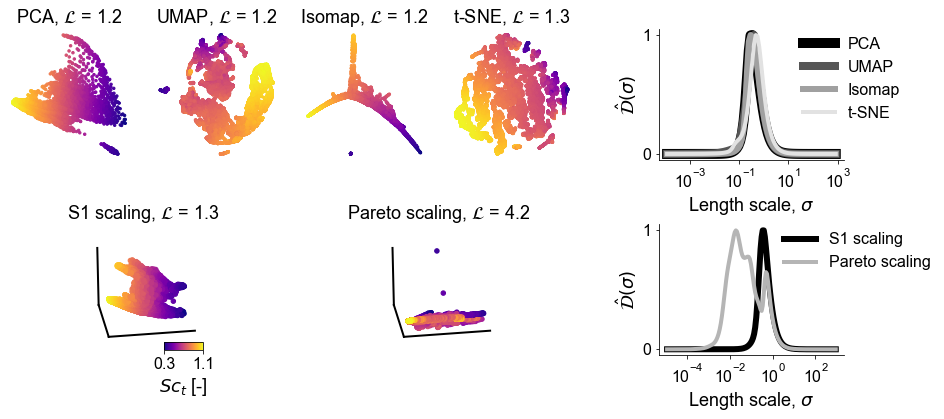

In [14]:
fig = plt.figure(figsize=(15, 6))
widths = [1, 1, 1, 1, 0.3, 1.5]
heights = [1, 0.2, 1]
spec = fig.add_gridspec(ncols=6, nrows=3, width_ratios=widths, height_ratios=heights)

# -------------------------------------------------------------------------------------------

for i, technique in enumerate(techniques):

    tic = time.perf_counter()

    print(technique)
    costs_list = pd.read_csv('../results/atmospheric-dispersion-' + technique + '-scalings-ranking-costs-2D-LDM.csv', sep = ',', header=None).to_numpy().ravel()

    best_cost = np.min(costs_list)
    best_scaling,  = np.where(costs_list==np.min(costs_list))
    best_scaling = best_scaling[0]
    print('\t\tBest scaling: ' + scalings_list[best_scaling])
    print('\t\tCost: ' + str(round(best_cost,1)))

    X_projected = compute_projection(X, technique, scalings_list[best_scaling], 2)

    toc = time.perf_counter()
    print(f'Time it took: {(toc - tic)/60:0.2f} minutes.')
    print('-'*50)

    ax = fig.add_subplot(spec[0,i])
    ax.scatter(X_projected[:,0], X_projected[:,1], c=X_Sct, s=6, cmap=colormap)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(technique + ', $\mathcal{L}$ = ' + str(round(best_cost,1)), fontsize=18)

print('2D projections done...')

# -------------------------------------------------------------------------------------------
    
ax = fig.add_subplot(spec[0,5])
color_map_colors = cm.get_cmap('Greys')
colors = np.flipud(color_map_colors(np.linspace(0.2, 1, 4)))

lws = [10,8,6,4]

for i, technique in enumerate(techniques):

    tic = time.perf_counter()
    
    print(technique)

    costs_list = pd.read_csv('../results/atmospheric-dispersion-' + technique + '-scalings-ranking-costs-2D-LDM.csv', sep = ',', header=None).to_numpy().ravel()

    best_cost = np.min(costs_list)
    
    best_scaling,  = np.where(costs_list==np.min(costs_list))
    best_scaling = best_scaling[0]
    print('\t\tBest scaling: ' + scalings_list[best_scaling])
    
    X_projected = compute_projection(X, technique, scalings_list[best_scaling], 2)
    
    variance_data = analysis.compute_normalized_variance(X_projected, 
                                                         X_Sct[:,None], 
                                                         depvar_names=['Sct'],
                                                         bandwidth_values=np.logspace(-4, 3, 100))

    cost = analysis.cost_function_normalized_variance_derivative(variance_data, 
                                                                 penalty_function=penalty, 
                                                                 power=power,
                                                                 norm=norm,
                                                                 integrate_to_peak=False)

    derivative, sigma, _ = analysis.normalized_variance_derivative(variance_data)
    
    plt.semilogx(sigma, derivative['Sct'], '-', c=colors[i], lw=lws[i], label=technique, zorder=100)
    
    toc = time.perf_counter()
    print(f'Time it took: {(toc - tic)/60:0.2f} minutes.')
    print('-'*50)
    
plt.xlabel('Length scale, $\sigma$', fontsize=18)
plt.ylabel('$\hat{\mathcal{D}}(\sigma)$', fontsize=18)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(fontsize=16)
plt.yticks([0,1], fontsize=16)
plt.minorticks_off()
plt.legend(ncol=1, fontsize=16, frameon=False, bbox_to_anchor=(0.7,1.05))

print('D-hats for 2D projections done...')

# -------------------------------------------------------------------------------------------

ax = fig.add_subplot(spec[2,0:2], projection='3d')

X_projected = compute_projection(X, 'PCA', PCA_3D_LDM_best_scaling, 3)

scat_a = ax.scatter(X_projected[:,0], X_projected[:,1], X_projected[:,2], c=X_Sct, s=20, alpha=1, cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.line.set_linewidth(2)
ax.tick_params(pad=5)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.view_init(elev=20, azim=-100)
plt.title("S1 scaling, $\mathcal{L}$ = " + str(round(best_cost,1)), fontsize=18)
cbaxes = inset_axes(ax, width="30%", height="6%", loc='lower right')
cbar = plt.colorbar(scat_a, ticks=[np.min(X_Sct),np.max(X_Sct)], orientation='horizontal', aspect=8, cax=cbaxes)
cbar.ax.set_xlabel('$Sc_t$ [-]', fontsize=18, rotation=0)
cbar.ax.set_xticklabels([str(round(np.min(X_Sct),1)), str(round(np.max(X_Sct),1))])
for t in cbar.ax.get_xticklabels():
     t.set_fontsize(16)

# -------------------------------------------------------------------------------------------

ax = fig.add_subplot(spec[2,2:4], projection='3d')

X_projected = compute_projection(X, 'PCA', PCA_3D_LDM_worst_scaling, 3)

scat_a = ax.scatter(X_projected[:,0], X_projected[:,1], X_projected[:,2], c=X_Sct, s=20, alpha=1, cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.line.set_linewidth(2)
ax.tick_params(pad=5)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.view_init(elev=20, azim=-100)
plt.title("Pareto scaling, $\mathcal{L}$ = " + str(round(worst_cost,1)), fontsize=18)

print('3D projections done...')

# -------------------------------------------------------------------------------------------

ax = fig.add_subplot(spec[2,5])
color_map_colors = cm.get_cmap('Greys')
colors = np.flipud(color_map_colors(np.linspace(0.4, 1, 2)))

plt.semilogx(sigma_PCA_3D_LDM_best_scaling[40::], derivative_PCA_3D_LDM_best_scaling['Sct'][40::], '-', color=colors[0], lw=6, label='S1 scaling')
plt.semilogx(sigma_3D_LDM_worst_scaling[40::], derivative_3D_LDM_worst_scaling['Sct'][40::], '-', color=colors[1], lw=4, label='Pareto scaling')
plt.xlabel('Length scale, $\sigma$', fontsize=18)
plt.ylabel('$\hat{\mathcal{D}}(\sigma)$', fontsize=18)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(fontsize=16)
plt.yticks([0,1], fontsize=16)
plt.minorticks_off()
plt.legend(ncol=1, fontsize=16, frameon=False, bbox_to_anchor=(0.6,1.05))

print('D-hats for 3D projections done...')

if save_figures: plt.savefig('../figures/Figure-6-projections.png', dpi=200, bbox_inches='tight')

<a id=regression></a>
***

## Nonlinear regression of the turbulent Schmidt number, $Sc_t$, using artificial neural networks (ANNs)

[Go to the top](#top-page)

<p style="color:green;">► You only need to run this once to generate the `csv` files in `../results/`:</p>

In [ ]:
val_split = 0.2
b_size = 100
n_epochs = 500
n_components = 3
train_perc = 80
random_seed = 100

sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=random_seed, verbose=False)
(idx_train, idx_test) = sample_random.random(train_perc)

for technique in techniques:
    
    MAE = []
    MAE_test = []
    MAE_train = []

    MaxAE = []
    MaxAE_test = []
    MaxAE_train = []

    for scaling in scalings_list:

        print(scaling)

        total_tic = time.perf_counter()
        
        tf.random.set_seed(random_seed)

        X_projected = compute_projection(X, method=technique, scaling=scaling, n_components=n_components)
            
        # Model architecture:
        model_architecture = Sequential([
        Dense(5, input_dim=n_components, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
        Dense(5, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
        Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='zeros')
        ])

        # Generate train input and output data:
        X_projected_train = X_projected[idx_train,:]
        X_Sct_train = X_Sct[idx_train]

        # Generate test input and output data:
        X_projected_test = X_projected[idx_test,:]
        X_Sct_test = X_Sct[idx_test]

        # Initialize the model:
        model_architecture.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.mean_squared_error, metrics=['mse'])

        # Get the initial weights:
        weights_and_biases = model_architecture.get_weights()

        # Fit the model with the training data:
        history = model_architecture.fit(X_projected_train, X_Sct_train, batch_size=b_size, epochs=n_epochs, validation_split=val_split, verbose=0)

        # Predict the test data only:
        X_Sct_test_predicted = model_architecture.predict(X_projected_test).ravel()

        # Predict the train data only:
        X_Sct_train_predicted = model_architecture.predict(X_projected_train).ravel()

        # Predict all data:
        X_Sct_predicted = model_architecture.predict(X_projected).ravel()

        # Set the weights back to initial ones so that the network can be trained de nouveau:
        model_architecture.set_weights(weights_and_biases)

        error_test = analysis.mean_absolute_error(X_Sct_test, X_Sct_test_predicted)
        MAE_test.append(error_test)

        error_train = analysis.mean_absolute_error(X_Sct_train, X_Sct_train_predicted)
        MAE_train.append(error_train)

        error = analysis.mean_absolute_error(X_Sct, X_Sct_predicted)
        MAE.append(error)

        max_error_test = analysis.max_absolute_error(X_Sct_test, X_Sct_test_predicted)
        MaxAE_test.append(max_error_test)

        max_error_train = analysis.max_absolute_error(X_Sct_train, X_Sct_train_predicted)
        MaxAE_train.append(max_error_train)

        max_error = analysis.max_absolute_error(X_Sct, X_Sct_predicted)
        MaxAE.append(max_error)

        print(error)
        print(max_error)

        total_toc = time.perf_counter()
        print(f'\nTotal time: {(total_toc - total_tic)/60:0.1f} minutes.')

    np.savetxt('../results/' + data_tag + '-' + technique + '-ANN-MAE-' + str(n_components) + 'D-LDM.csv', (MAE), delimiter=',', fmt='%.16e')
    np.savetxt('../results/' + data_tag + '-' + technique + '-ANN-MaxAE-' + str(n_components) + 'D-LDM.csv', (MaxAE), delimiter=',', fmt='%.16e')

    np.savetxt('../results/' + data_tag + '-' + technique + '-ANN-MAE-test-' + str(n_components) + 'D-LDM.csv', (MAE_test), delimiter=',', fmt='%.16e')
    np.savetxt('../results/' + data_tag + '-' + technique + '-ANN-MaxAE-test-' + str(n_components) + 'D-LDM.csv', (MaxAE_test), delimiter=',', fmt='%.16e')

    np.savetxt('../results/' + data_tag + '-' + technique + '-ANN-MAE-train-' + str(n_components) + 'D-LDM.csv', (MAE_train), delimiter=',', fmt='%.16e')
    np.savetxt('../results/' + data_tag + '-' + technique + '-ANN-MaxAE-train-' + str(n_components) + 'D-LDM.csv', (MaxAE_train), delimiter=',', fmt='%.16e')

<a id=plot-scalings-ranking></a>

***

## Plot the scalings ranking vs. MAE regression errors for all four reduction techniques

[Go to the top](#top-page)

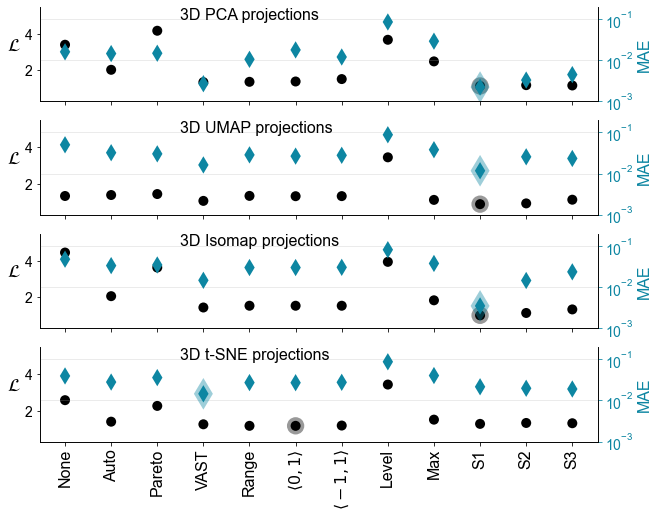

In [18]:
error_color = '#0d86a2'
fig= plt.figure(figsize=(10,8))
x_range = [i for i in range(0,len(scalings_list))]
widths = [1]
heights = [1 for i in range(0,len(techniques))]
spec = fig.add_gridspec(ncols=1, nrows=len(techniques), width_ratios=widths, height_ratios=heights)

for i, technique in enumerate(techniques):

    MAE = pd.read_csv('../results/atmospheric-dispersion-' + technique + '-ANN-MAE-test-3D-LDM.csv', sep = ',', header=None).to_numpy().ravel()
    MaxAE = pd.read_csv('../results/atmospheric-dispersion-' + technique + '-ANN-MaxAE-test-3D-LDM.csv', sep = ',', header=None).to_numpy().ravel()
    costs = pd.read_csv('../results/atmospheric-dispersion-' + technique + '-scalings-ranking-costs-3D-LDM.csv', sep = ',', header=None).to_numpy().ravel()

    idx = np.where(costs==np.min(costs))
    idx_smallest_cost = idx[0][0]
    idx = np.where(MAE==np.min(MAE))
    idx_smallest_MAE = idx[0][0]

    ax1 = fig.add_subplot(spec[i:i+1,0])
    ax1.scatter(x_range, costs, c='k', marker='o', s=100, edgecolor='none', alpha=1, zorder=2)
    ax1.scatter(x_range[idx_smallest_cost], costs[idx_smallest_cost], c='k', marker='o', s=300, edgecolor='none', alpha=0.4, zorder=10)
    ax1.set_yticks([2,4])
    ax1.set_yticklabels([2,4], fontsize=14)
    ax1.set_ylabel('$\mathcal{L}$', fontsize=18, rotation=0, horizontalalignment='right')
    ax1.set_ylim([0.3, 5.5])
    ax1.spines["top"].set_visible(False)
    if technique == 't-SNE':
        ax1.set_xticks(x_range, tex_scalings_list, fontsize=16, rotation=90)
    else:
        ax1.set_xticks(x_range, [])
        
    ax2 = ax1.twinx()
    ax2.scatter(x_range, MAE, c=error_color, marker='d', s=150, edgecolor='none', alpha=1, zorder=2)
    ax2.scatter(x_range[idx_smallest_MAE], MAE[idx_smallest_MAE], c=error_color, marker='d', s=500, edgecolor='none', alpha=0.4, zorder=10)
    ax2.set_ylabel('MAE', fontsize=16, color=error_color)
    ax2.set_yticks([0.001,0.01,0.1])
    ax2.set_yticklabels([0.001,0.01,0.1], fontsize=14)
    ax2.set_yscale('log')
    ax2.set_ylim([0.001, 0.2])
    ax2.tick_params('y', colors=error_color)
    ax2.minorticks_off()
    ax2.spines["top"].set_visible(False)

    plt.grid(alpha=0.3, zorder=10)
    plt.text(2.5,0.1, '3D ' + technique + ' projections', fontsize=16)
    
plt.savefig('../figures/atmospheric-dispersion-' + technique + '-ANN-regression-results-3D-LDM.svg', dpi=200, bbox_inches='tight')

***